In [13]:
import numpy as np
import matplotlib.pyplot as plt
import lime
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Folder with NIRSPEC spectra
data_folder = Path(f'./data')

# CEERs 1027 redshift
z_obj = 7.8334

# Multiple spectra from the same galaxy observed with diference dispensers
spec_list = data_folder.glob('*.fits')
spec_list = list(spec_list)

In [29]:
s = spec_list[1]

LiMe INFO: Normalizing input flux by 1.573140441358099e-09


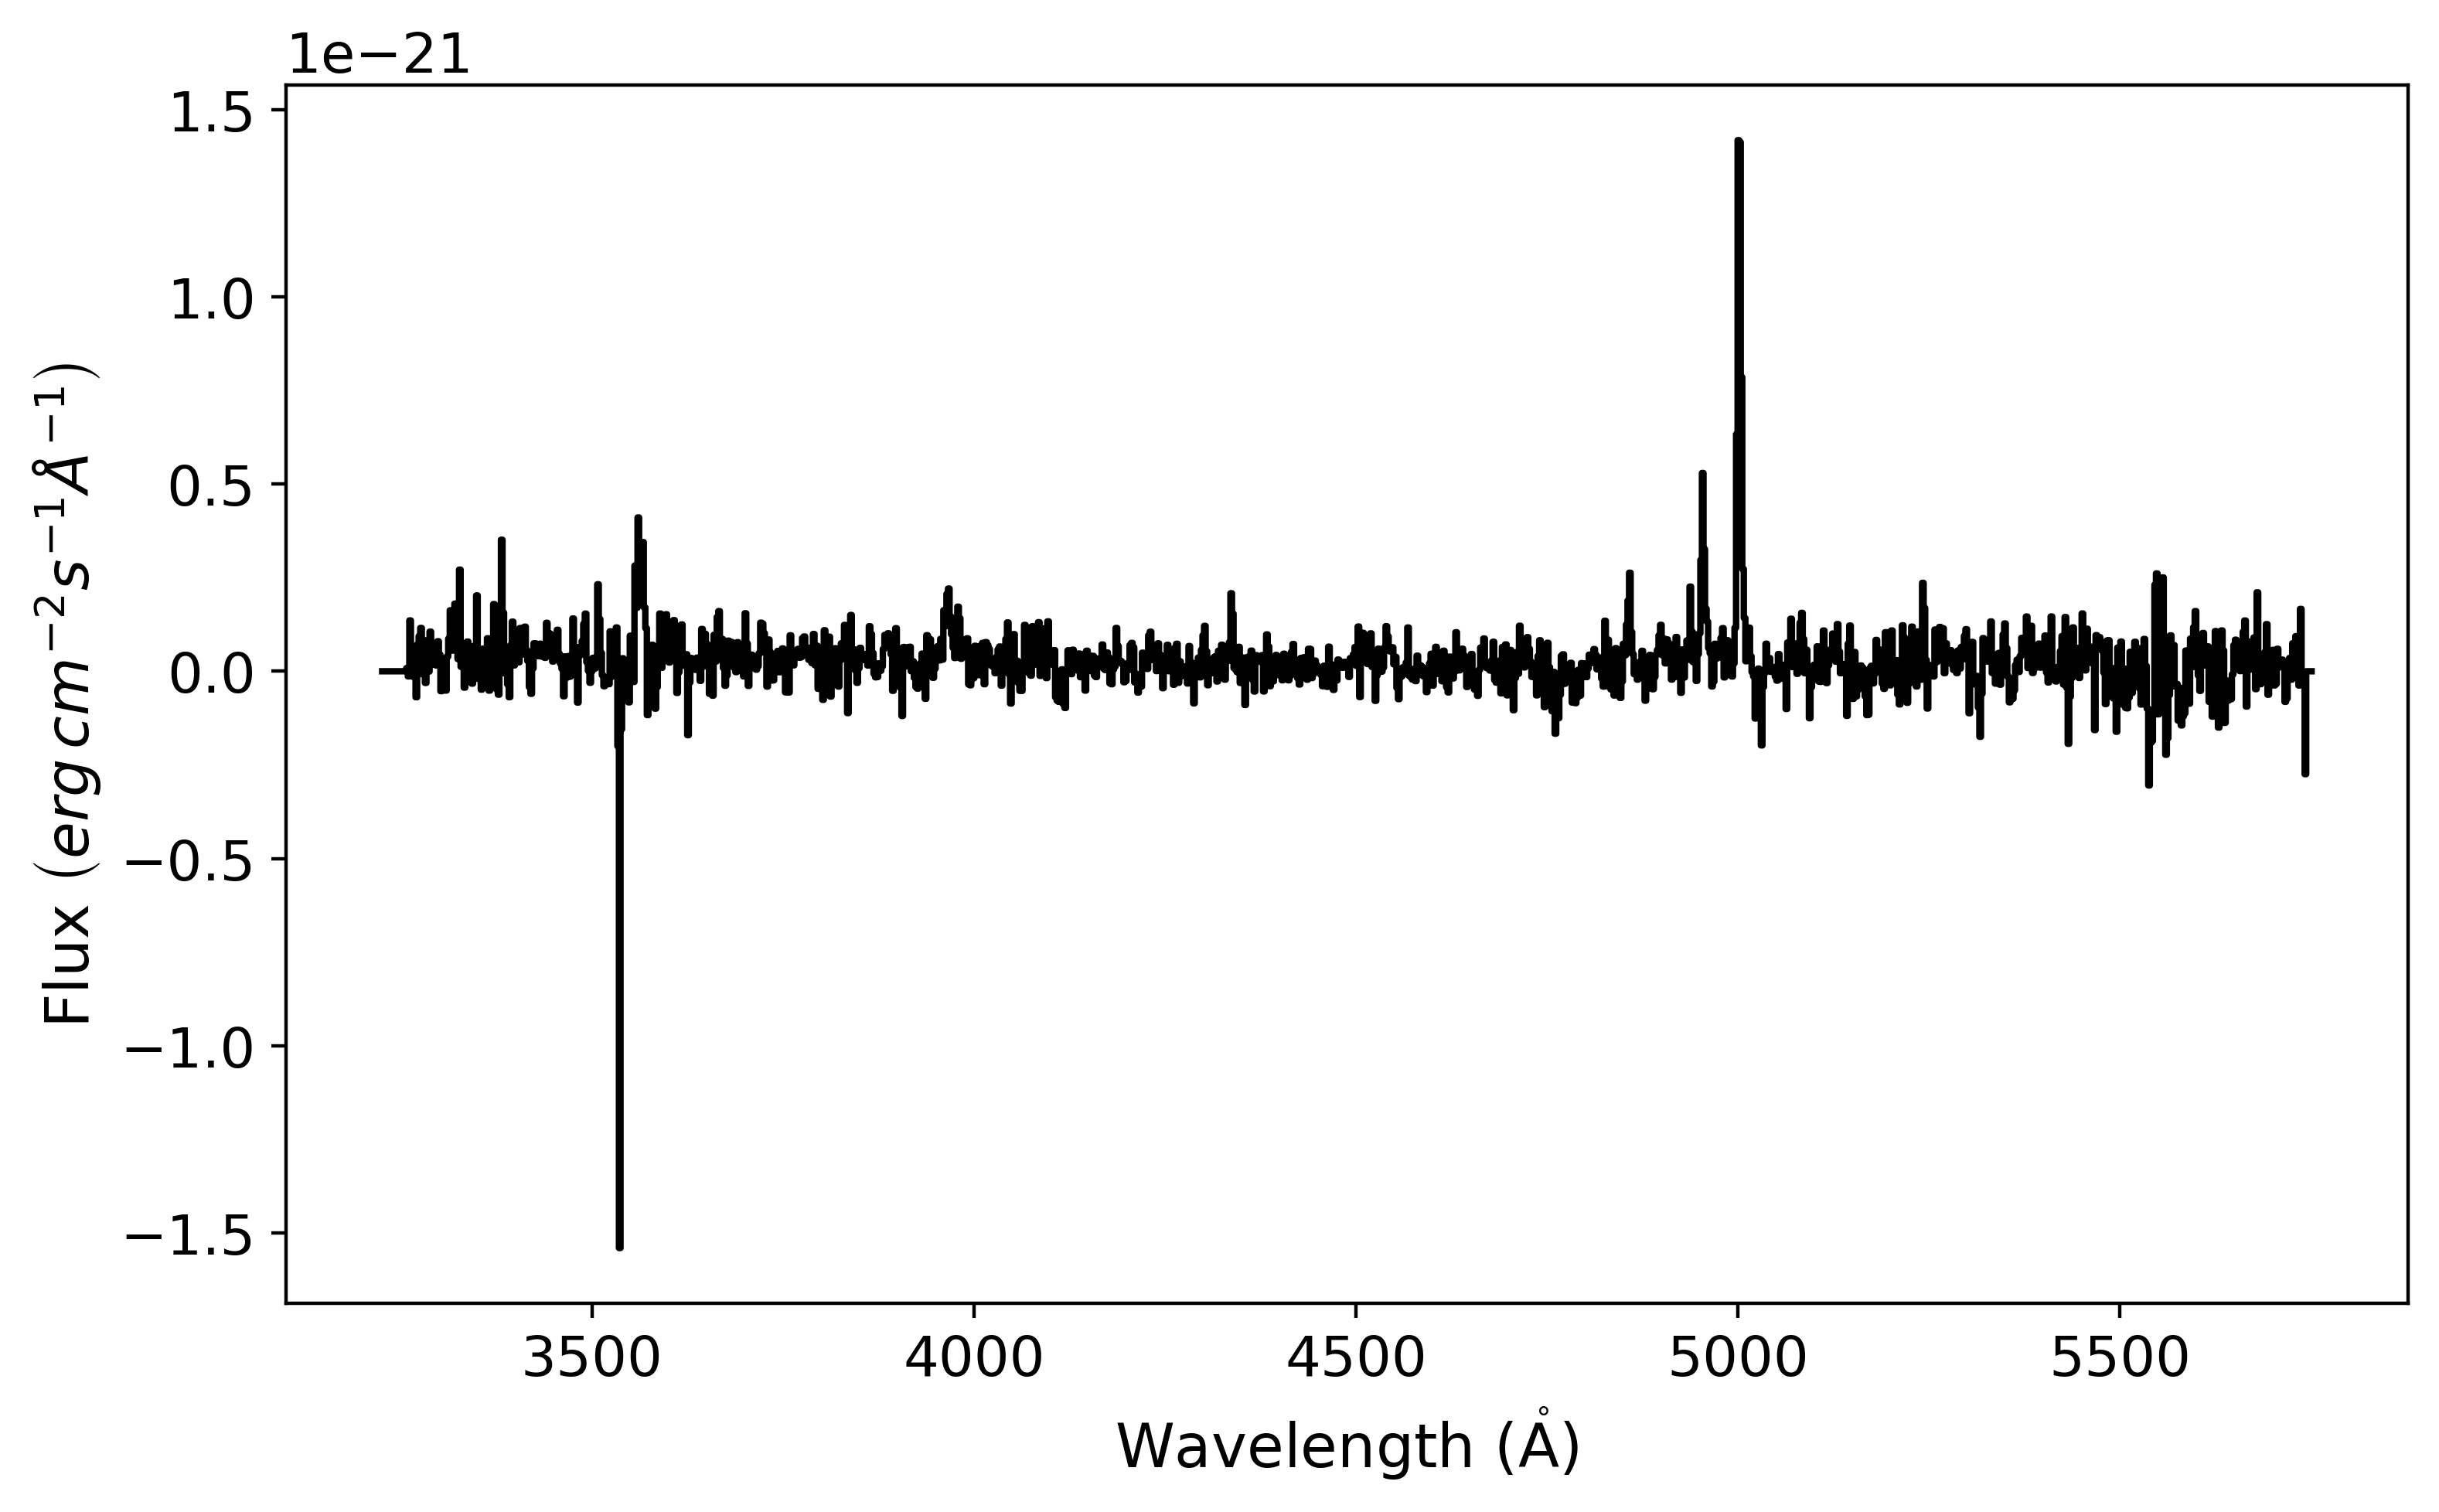

In [36]:
spec = lime.Spectrum.from_file(s, 'nirspec', redshift=z_obj)

# Convert units as necessary
spec.unit_conversion(wave_units_out='Angstrom', flux_units_out='FLAM')

# Visualize the spectrum
spec.plot.spectrum(rest_frame=True)

In [31]:
# Compute the FWHM curve for the instrument observation (removing data mask)
wave_obs = spec.wave.data
deltalamb_arr = np.diff(wave_obs)
R_arr = wave_obs[1:] / deltalamb_arr
FWHM_arr = wave_obs[1:] / R_arr

In [80]:
l = spec.wave.data
f = spec.flux.data

In [78]:
full_df = lime.line_bands(vacuum=True)

# Cropping to the "main lines"
candidate_lines = ["H1_1216A", "He2_1640A", "Ne5_3427A", "O2_3727A", "H1_4342A",
                   "H1_4863A", "O3_4960A", "O3_5008A", "H1_6565A", "S2_6718A",
                   "He1_10833A"]
# candidate_lines = ["O2_3727A", "H1_4863A", "O3_4960A", "O3_5008A", "H1_6565A"]
lines_df = full_df.loc[candidate_lines]

# The theoretical wavelengths (vacuum) are in the first column:
wave_theo = lines_df.wavelength.to_numpy()

In [84]:
def wavelength_to_index(wave, wave_theo):
    return np.argmin(np.abs(wave - wave_theo))

In [83]:
deltalamb_arr

array([17.93765914, 17.93767441, 17.93768958, ..., 17.90044893,
       17.90038178, 17.90034677])

In [82]:
spec.wave.data[0]

28489.901560463204

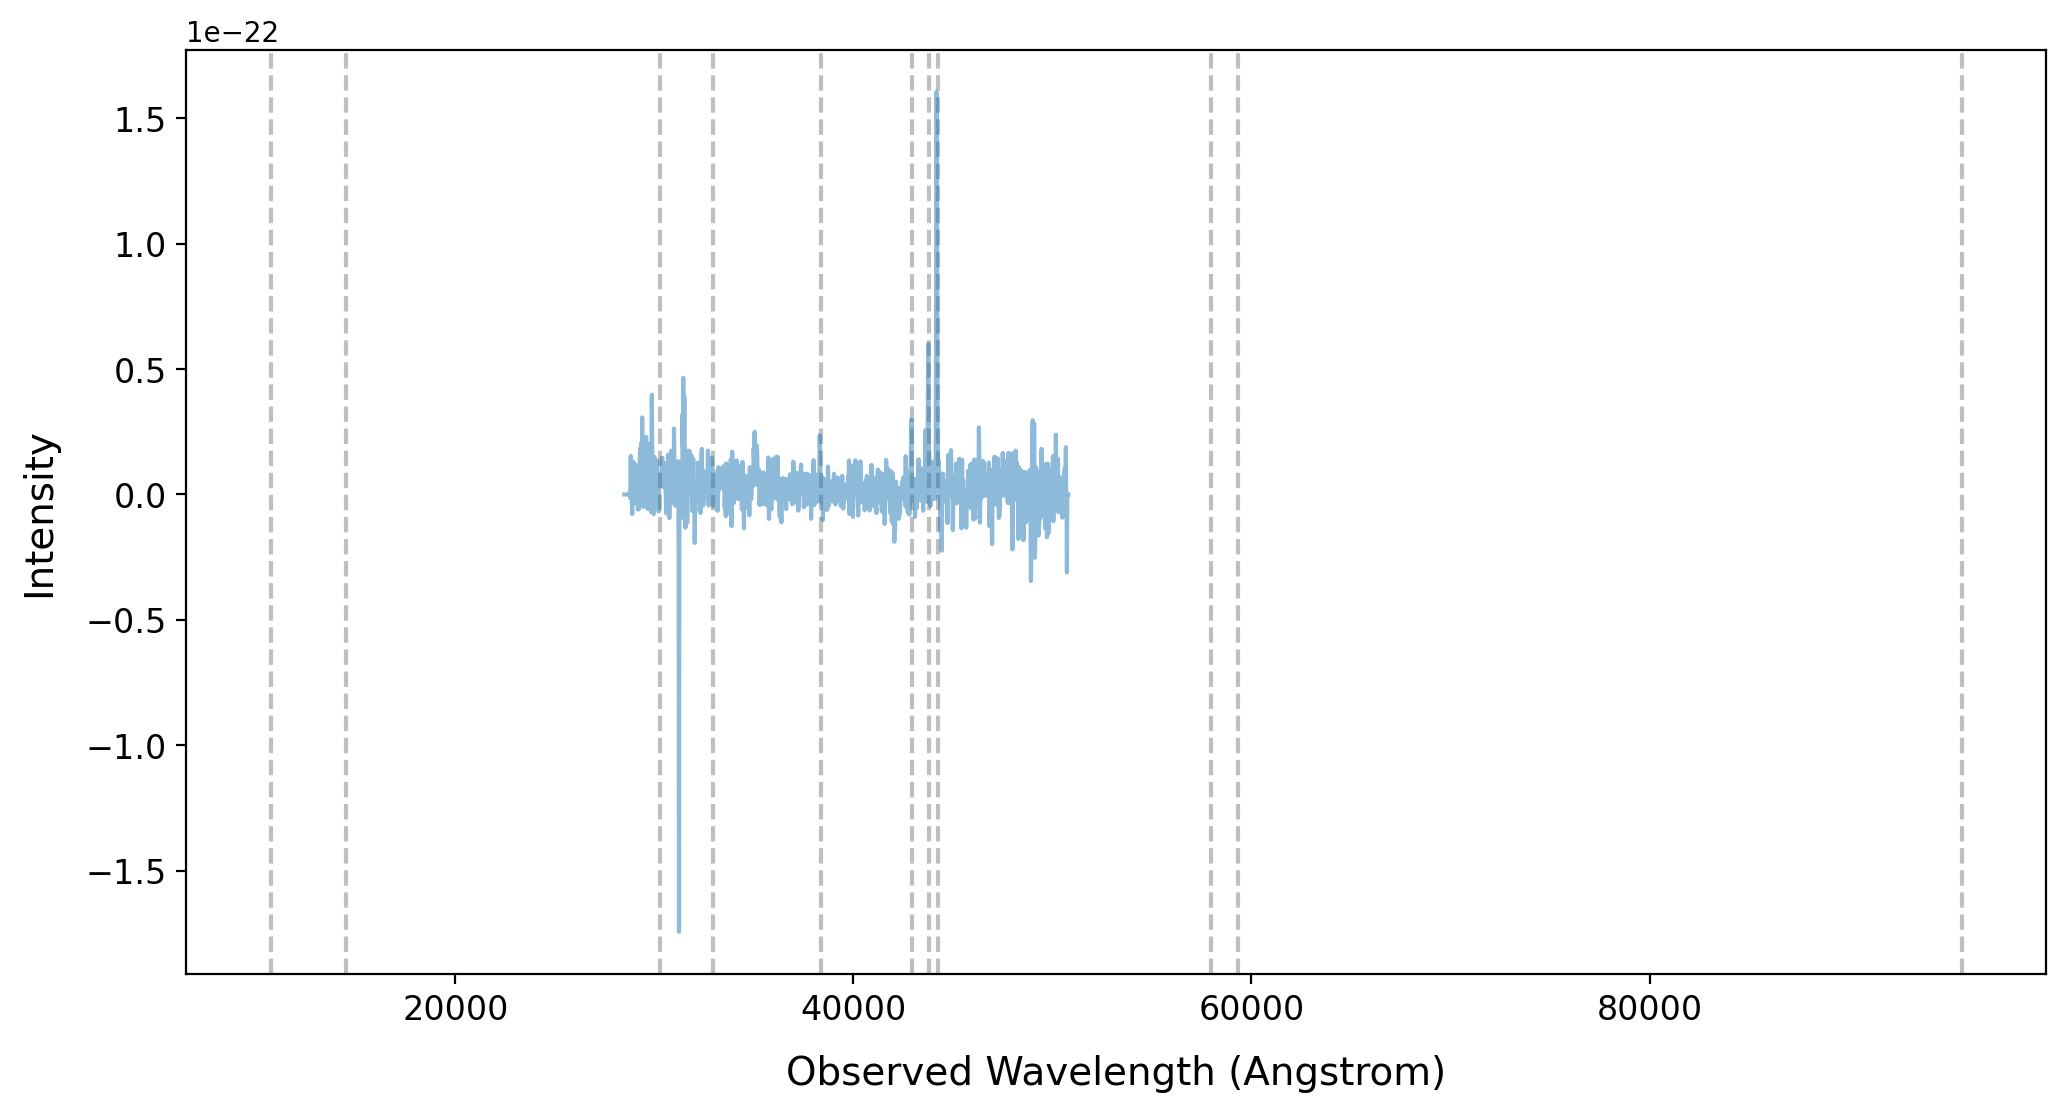

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(l, f, alpha=0.5)

for w in wave_theo:
    corrected_w = w * (1 + spec.redshift + 0.0)
    ax.axvline(corrected_w, color='grey', linestyle='--', zorder=0, alpha=0.5)

ax.set_ylabel("Intensity", fontsize=14, labelpad=10)
ax.set_xlabel("Observed Wavelength (Angstrom)", fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)